<a href="https://colab.research.google.com/github/shubhsharma097/Cross-Lingual-Knowledge-Transfer/blob/main/Cross_Lingual_Knowledge_Transfer_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<>:131: SyntaxWarning: invalid escape sequence '\M'
<>:131: SyntaxWarning: invalid escape sequence '\M'
/tmp/ipython-input-1425831317.py:131: SyntaxWarning: invalid escape sequence '\M'
  print("\Measuring translation performance:")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.7 MB/s eta 0:00:00
Successfully logged in to Hugging Face

Loading model: google/gemma-2-2b-it...


tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

de-en/train-00000-of-00016.parquet:   0%|          | 0.00/384M [00:00<?, ?B/s]

de-en/train-00001-of-00016.parquet:   0%|          | 0.00/130M [00:00<?, ?B/s]

de-en/train-00002-of-00016.parquet:   0%|          | 0.00/102M [00:00<?, ?B/s]

de-en/train-00003-of-00016.parquet:   0%|          | 0.00/176M [00:00<?, ?B/s]

de-en/train-00004-of-00016.parquet:   0%|          | 0.00/282M [00:00<?, ?B/s]

de-en/train-00005-of-00016.parquet:   0%|          | 0.00/183M [00:00<?, ?B/s]

de-en/train-00006-of-00016.parquet:   0%|          | 0.00/251M [00:00<?, ?B/s]

de-en/train-00007-of-00016.parquet:   0%|          | 0.00/336M [00:00<?, ?B/s]

de-en/train-00008-of-00016.parquet:   0%|          | 0.00/232M [00:00<?, ?B/s]

de-en/train-00009-of-00016.parquet:   0%|          | 0.00/224M [00:00<?, ?B/s]

de-en/train-00010-of-00016.parquet:   0%|          | 0.00/196M [00:00<?, ?B/s]

de-en/train-00011-of-00016.parquet:   0%|          | 0.00/340M [00:00<?, ?B/s]

de-en/train-00012-of-00016.parquet:   0%|          | 0.00/401M [00:00<?, ?B/s]

de-en/train-00013-of-00016.parquet:   0%|          | 0.00/307M [00:00<?, ?B/s]

de-en/train-00014-of-00016.parquet:   0%|          | 0.00/305M [00:00<?, ?B/s]

de-en/train-00015-of-00016.parquet:   0%|          | 0.00/231M [00:00<?, ?B/s]

de-en/validation-00000-of-00001.parquet:   0%|          | 0.00/495k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/34782245 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2998 [00:00<?, ? examples/s]


First example:
English: Munich 1856: Four maps that will change your view of the city
German: München 1856: Vier Karten, die Ihren Blick auf die Stadt verändern

Translating 50 examples...


Translating: 100%|██████████| 50/50 [06:11<00:00,  7.44s/it]


Translation complete.
\Measuring translation performance:

BLEU Score: 4.16
ChrF Score: 35.52

RESULTS SUMMARY
| Model                | Language Pair   | Dataset   |   Sample Size |   BLEU |   ChrF |
|:---------------------|:----------------|:----------|--------------:|-------:|-------:|
| google/gemma-2-2b-it | English→German  | wmt19     |            50 |   4.16 |  35.52 |

SAMPLE TRANSLATIONS

Example 1:
  Source:     Munich 1856: Four maps that will change your view of the city
  Model:      München 1856: Vier Karten, die Ihre Sicht auf die Stadt verändern

**Explanation:**

* **München 1856:** This translates directly to "Munich 1856".
* **Vier Karten:** This means "Four Maps" in German.
* **Die Sicht auf die Stadt:** This translates to "the view of the city" in German.
* **Verändern:** This means "change" in German.


This title is concise and informative, accurately conveying the content of the text.
  Reference:  München 1856: Vier Karten, die Ihren Blick auf die Stadt veränder

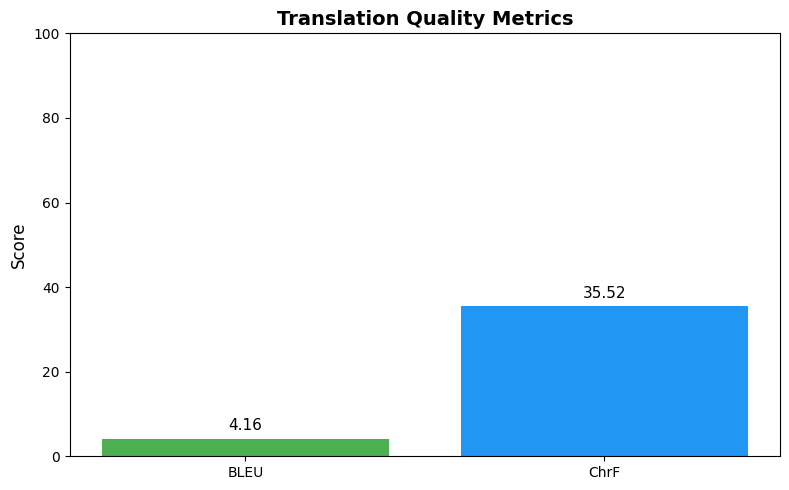


ERROR ANALYSIS

Average source length: 19.5 words
Average reference length: 16.0 words
Average translation length: 91.9 words

Average translation/source length ratio: 5.31

Shortest translation:
  Source: Civil rights group issues travel warning for Missouri
  Translation: ** Das Unternehmen plant, 500 Mitarbeiter zu entlassen.

Let me know if you'd like me to translate any other text!
  Reference: Bürgerrechtsgruppe veröffentlicht Reisewarnung für Missouri

Longest translation:
  Source: In 2015, the "Casa Don Bosco" nursery was built – in the architectural style of the original mental asylum building, which had been destroyed in the Second World War in bomb attacks.
  Translation: Im Jahr 2015 wurde die "Casa Don Bosco" Kindertagesstätte errichtet – im architektonischen Stil des ursprünglichen psychiatrischen Krankenhauses, das im Zweiten Weltkrieg durch Bombenangriffe zerstört worden war. 


Here's a breakdown of the changes:

* **"Casa Don Bosco"** remains the same as it is a wel

In [ ]:
# Cross-Lingual Knowledge Transfer - Direction 1
!pip install -q transformers datasets accelerate sacrebleu sentencepiece

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import pandas as pd
from sacrebleu import corpus_bleu, corpus_chrf
from tqdm import tqdm
import json
from huggingface_hub import login
from google.colab import userdata

# Experiment configuration
CONFIG = {
    "model_name": "google/gemma-2-2b-it",
    "source_lang": "English",
    "target_lang": "German",  # Langauge Pair: English-to-German
    "dataset_name": "wmt19",
    "dataset_config": "de-en",
    "num_samples": 50,
    "temperature": 0.1,
    "max_new_tokens": 256,
}

# Retrieve the Hugging Face token
hf_token = userdata.get('HF_TOKEN')

if hf_token:
    try:
        login(token=hf_token)
        print("Successfully logged in to Hugging Face")
    except Exception as e:
        print(f"Login failed to Huggin Face: {e}")
else:
    print("Token not found!")


# Load Model and Tokenizer
print(f"\nLoading model: {CONFIG['model_name']}...")

tokenizer = AutoTokenizer.from_pretrained(
    CONFIG['model_name'],
)
model = AutoModelForCausalLM.from_pretrained(
    CONFIG['model_name'],
    device_map="auto",
    torch_dtype=torch.bfloat16,
)


# Load WMT19 German-English dataset (using validation split)
dataset = load_dataset(CONFIG['dataset_name'], CONFIG['dataset_config'], split="validation")

# Take 50 samples
test_data = dataset.select(range(CONFIG['num_samples']))

print("\nFirst example:")
print(f"English: {test_data[0]['translation']['en']}")
print(f"German: {test_data[0]['translation']['de']}")


# Translation Function to
# Translate the source language(s) to the target language(s) with the LLM(s)
# input: text to translate, source langauge, target langauge, hugging face model & hugging face tokenizer
# output: translated text string
def translate(source_text, source_lang, target_lang, model, tokenizer):
    # prompt to feed into gemma
    prompt = f"""Translate the following {source_lang} text to {target_lang}.

{source_lang}: {source_text}
{target_lang}:"""

    # Tokenize input
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Generate translation
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=CONFIG['max_new_tokens'],
            temperature=CONFIG['temperature'],
            do_sample=False,  # Deterministic for evaluation
            pad_token_id=tokenizer.eos_token_id,
        )

    # Decode output
    full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract just the translation (after the last colon)
    try:
        translation = full_output.split(f"{target_lang}:")[-1].strip()
        # Remove any remaining prompt text
        if source_text in translation:
            translation = translation.replace(source_text, "").strip()
    except:
        translation = full_output

    return translation

# Translate the whole dataset
print(f"\nTranslating {len(test_data)} examples...")

translations = []

for example in tqdm(test_data, desc="Translating"):
    source = example['translation']['en']
    reference = example['translation']['de']

    # Generate translation
    translation = translate(
        source,
        CONFIG['source_lang'],
        CONFIG['target_lang'],
        model,
        tokenizer
    )

    translations.append({
        "source": source,
        "reference": reference,
        "translation": translation
    })

print("Translation complete.")


# Measure the translation performance with translation metrics
# Using BLEU & ChrF

print("\Measuring translation performance:")

# Extract lists for evaluation
references = [[t["reference"] for t in translations]]
hypotheses = [t["translation"] for t in translations]

# Calculate BLEU
bleu = corpus_bleu(hypotheses, references)
print(f"\nBLEU Score: {bleu.score:.2f}")

# Calculate ChrF
chrf = corpus_chrf(hypotheses, references)
print(f"ChrF Score: {chrf.score:.2f}")


# Present your findings with a table or plot
# Results Analysis and Visualization

# Create results table
results_df = pd.DataFrame({
    "Model": [CONFIG['model_name']],
    "Language Pair": [f"{CONFIG['source_lang']}→{CONFIG['target_lang']}"],
    "Dataset": [CONFIG['dataset_name']],
    "Sample Size": [CONFIG['num_samples']],
    "BLEU": [f"{bleu.score:.2f}"],
    "ChrF": [f"{chrf.score:.2f}"],
})

print("\n" + "="*80)
print("RESULTS SUMMARY")
print("="*80)
print(results_df.to_markdown(index=False))

# Show sample translations
print("\n" + "="*80)
print("SAMPLE TRANSLATIONS")
print("="*80)

num_samples_to_show = 5
for i in range(min(num_samples_to_show, len(translations))):
    print(f"\nExample {i+1}:")
    print(f"  Source:     {translations[i]['source']}")
    print(f"  Model:      {translations[i]['translation']}")
    print(f"  Reference:  {translations[i]['reference']}")



import matplotlib.pyplot as plt

# Create bar chart of scores
metrics = ['BLEU', 'ChrF']
scores = [bleu.score, chrf.score]

plt.figure(figsize=(8, 5))
plt.bar(metrics, scores, color=['#4CAF50', '#2196F3'])
plt.ylabel('Score', fontsize=12)
plt.title('Translation Quality Metrics', fontsize=14, fontweight='bold')
plt.ylim(0, 100)

# Add score labels on bars
for i, score in enumerate(scores):
    plt.text(i, score + 2, f'{score:.2f}', ha='center', fontsize=11)

plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


# ============================================================================
# SECTION 9: Error Analysis
# ============================================================================

print("\n" + "="*80)
print("ERROR ANALYSIS")
print("="*80)

# Calculate translation lengths for comparison
source_lengths = [len(t['source'].split()) for t in translations]
ref_lengths = [len(t['reference'].split()) for t in translations]
trans_lengths = [len(t['translation'].split()) for t in translations]

print(f"\nAverage source length: {sum(source_lengths)/len(source_lengths):.1f} words")
print(f"Average reference length: {sum(ref_lengths)/len(ref_lengths):.1f} words")
print(f"Average translation length: {sum(trans_lengths)/len(trans_lengths):.1f} words")

# Calculate length ratio
length_ratios = [t_len / s_len if s_len > 0 else 0 for t_len, s_len in zip(trans_lengths, source_lengths)]
avg_ratio = sum(length_ratios) / len(length_ratios) if length_ratios else 0
print(f"\nAverage translation/source length ratio: {avg_ratio:.2f}")

# Find shortest and longest translations
sorted_by_length = sorted(enumerate(translations), key=lambda x: len(x[1]['translation']))

print("\nShortest translation:")
idx, shortest = sorted_by_length[0]
print(f"  Source: {shortest['source']}")
print(f"  Translation: {shortest['translation']}")
print(f"  Reference: {shortest['reference']}")

print("\nLongest translation:")
idx, longest = sorted_by_length[-1]
print(f"  Source: {longest['source']}")
print(f"  Translation: {longest['translation']}")
print(f"  Reference: {longest['reference']}")

# ============================================================================
# SECTION 10: Save Results
# ============================================================================

print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80)

# Save translations to JSON
output_file = "translation_results.json"
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump({
        "config": CONFIG,
        "metrics": {
            "bleu": bleu.score,
            "chrf": chrf.score,
        },
        "translations": translations
    }, f, indent=2, ensure_ascii=False)

print(f"Results saved to {output_file}")

# Save as CSV for easy viewing
csv_file = "translation_results.csv"
translations_df = pd.DataFrame(translations)
translations_df.to_csv(csv_file, index=False)
print(f"Translations saved to {csv_file}")
